In [1]:
%matplotlib inline

In [2]:
import logging
import time
from platform import python_version
import random
from tqdm import tqdm
import re
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from sklearn.metrics import roc_auc_score
from torch.autograd import Variable

In [3]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-DGXS-32GB


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [5]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("torch==%s" % torch.__version__)
print("sklearn==%s" % sklearn.__version__)
print("transformers==%s" % transformers.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.7.5
pandas==1.2.0
numpy==1.19.4
torch==1.7.1+cu101
sklearn==0.24.0
transformers==3.5.0
matplotlib==3.3.3


In [6]:
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
# df = pd.read_csv('drive/MyDrive/train.csv')
df = pd.read_csv('./reviews.csv')
df.shape

(358957, 6)

In [9]:
df.head()

,user_id,prod_id,rating,label,date,review
0,923,0,3.0,-1,2014-12-08,The food at snack is a selection of popular Gr...
1,924,0,3.0,-1,2013-05-16,This little place in Soho is wonderful. I had ...
2,925,0,4.0,-1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...
3,926,0,4.0,-1,2011-07-28,This is a beautiful quaint little restaurant o...
4,927,0,4.0,-1,2010-11-01,Snack is great place for a casual sit down lu...


한 유저가 리뷰를 몇개를 작성했는지, 한 상품에 대해서 얼마나 많은 리뷰가 작성됐는지 카운트 하는 코드 (현재 모델에서는 사용하지는 않는 데이터, 추후에 어떤 식으로 사용할지 생각해보자)

In [10]:
def make_id_dict(df):
    user_id_dict = defaultdict(int)
    prod_id_dict = defaultdict(int)

    for idx in tqdm(range(df.shape[0])):
        user_id_dict[df.user_id[idx]] += 1

        prod_id_dict[df.prod_id[idx]] += 1
        
    return user_id_dict, prod_id_dict

In [11]:
user_id_dict, prod_id_dict = make_id_dict(df)

100%|██████████| 358957/358957 [00:06<00:00, 52772.45it/s]


위에서 만든 딕셔너리를 이용해 리스트로 변환하는 코드

In [12]:
user_id_count = []
prod_id_count = []

for idx in tqdm(range(df.shape[0])):
    user_id_count.append(user_id_dict[df.user_id[idx]])
    prod_id_count.append(prod_id_dict[df.prod_id[idx]])

100%|██████████| 358957/358957 [00:06<00:00, 51712.68it/s]


데이터에 위에서 만든 리스트 (해당 상품에 대한 리뷰 수, 사용자의 리뷰 수 추가)

In [13]:
df['user_id_count'] = user_id_count
df['prod_id_count'] = prod_id_count

In [14]:
df.head()

,user_id,prod_id,rating,label,date,review,user_id_count,prod_id_count
0,923,0,3.0,-1,2014-12-08,The food at snack is a selection of popular Gr...,39,210
1,924,0,3.0,-1,2013-05-16,This little place in Soho is wonderful. I had ...,1,210
2,925,0,4.0,-1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,2,210
3,926,0,4.0,-1,2011-07-28,This is a beautiful quaint little restaurant o...,1,210
4,927,0,4.0,-1,2010-11-01,Snack is great place for a casual sit down lu...,5,210


label이 -1로 되어있는 경우 0으로 변경 => fake review: 0, real review: 1

In [15]:
new_label_lst = []
for ele in df.label:
    if ele == -1:
        new_label_lst.append(0)
    else:
        new_label_lst.append(1)

In [16]:
df['label'] = new_label_lst

In [17]:
df.head()

,user_id,prod_id,rating,label,date,review,user_id_count,prod_id_count
0,923,0,3.0,0,2014-12-08,The food at snack is a selection of popular Gr...,39,210
1,924,0,3.0,0,2013-05-16,This little place in Soho is wonderful. I had ...,1,210
2,925,0,4.0,0,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,2,210
3,926,0,4.0,0,2011-07-28,This is a beautiful quaint little restaurant o...,1,210
4,927,0,4.0,0,2010-11-01,Snack is great place for a casual sit down lu...,5,210


real review데이터와 fake review 데이터를 분할 (훈련용 데이터 제작 용도)

In [18]:
df = df.sample(frac=1, random_state=random_seed)
df = df.reset_index(drop=True)

In [19]:
is_real = df['label'] == 1
df_real = df[is_real]

is_fake = df['label'] == 0
df_fake = df[is_fake]

assert df.shape[0] == df_real.shape[0] + df_fake.shape[0]

In [20]:
print(f'length of real review : {len(df_real)}')
print(f'length of fake review : {len(df_fake)}')

length of real review : 322097
length of fake review : 36860


real review 데이터와, fake review 데이터의 갯수를 같게 만들어주기 위한 작업

In [21]:
df_train_real = df_real[:10000].reset_index(drop=True)
df_val_real = df_real[10000:11000].reset_index(drop=True)
df_test_real = df_real[11000:13000].reset_index(drop=True)

df_train_fake = df_fake[:10000].reset_index(drop=True)
df_val_fake = df_fake[10000:11000].reset_index(drop=True)
df_test_fake = df_fake[11000:13000].reset_index(drop=True)

In [22]:
df_train = pd.concat([df_train_real, df_train_fake])
df_val = pd.concat([df_val_real, df_val_fake])
df_test = pd.concat([df_test_real, df_test_fake])

In [23]:
df_train = df_train.sample(frac=1, random_state=random_seed).reset_index(drop=True)
df_val = df_val.sample(frac=1, random_state=random_seed).reset_index(drop=True)
df_test = df_test.sample(frac=1, random_state=random_seed).reset_index(drop=True)

In [24]:
# 필요 없다고 생각되는 col들 삭제
df_train = df_train.drop(['user_id', 'prod_id', 'date'], axis=1)
df_val = df_val.drop(['user_id', 'prod_id', 'date'], axis=1)
df_test = df_test.drop(['user_id', 'prod_id', 'date'], axis=1)

In [25]:
df_train.head()

,rating,label,review,user_id_count,prod_id_count
0,5.0,0,i moved to greenpoint about a year ago and wa...,1,998
1,2.0,1,Usually I love this place. My parents ask to c...,1,677
2,3.0,1,"The ramen tastes like the ones in Japan, which...",26,7378
3,3.0,1,I like this place. I liked the bartender. I li...,21,369
4,4.0,0,"This place has great chicken and waffles, so g...",1,1217


문장 전처리 예시

In [26]:
sentence = df_train.review[0].lower()
print(f'origin sentence\n{sentence}', end='\n\n')

sentence = re.sub('[\d]+', 'NUMBER', sentence)
sentence = re.sub('[^\dA-Za-z\s]+', '', sentence)
sentence = re.sub('[NUMBER]+', 'NUMBER ', sentence)
print(f'changed sentence\n{sentence}')

# print(sentence.split())

origin sentence
i moved to greenpoint  about a year ago and was a lil sad about the cafe situation in the area... glad this place has opened!!! i can get a kick ass coffee on the way to work and i admit i have been stopping by on my way home for oysters/cheese and their addictive sidecars. the staff is nice (hot) and it's a good addition to the hood.

changed sentence
i moved to greenpoint  about a year ago and was a lil sad about the cafe situation in the area glad this place has opened i can get a kick ass coffee on the way to work and i admit i have been stopping by on my way home for oysterscheese and their addictive sidecars the staff is nice hot and its a good addition to the hood


문장 전처리를 수행한 뒤, 데이터에 속한 단어들의 갯수 카운팅하는 함수

In [27]:
def make_word_dict(df):
    real_review_dict = dict()
    fake_review_dict = dict()

    for i in tqdm(range(df.shape[0])):
        # word_lst = df.review[i].lower().split()
        
        sentence = df.review[i].lower()
        sentence = re.sub('[\d]+', 'NUMBER', sentence)
        sentence = re.sub('[^A-Za-z\s]', '', sentence)
        sentence = re.sub('[NUMBER]+', 'NUMBER', sentence)
        word_lst = sentence.split()

        if df.label[i] == 1:
            for ele in word_lst:
                if ele in real_review_dict:
                    real_review_dict[ele] += 1
                else:
                    real_review_dict[ele] = 1

        else:
            for ele in word_lst:
                if ele in fake_review_dict:
                    fake_review_dict[ele] += 1
                else:
                    fake_review_dict[ele] = 1

    return real_review_dict, fake_review_dict

단어들의 갯수를 이용해, 어떤 단어를 제거할지 찾는 함수

In [28]:
def make_del_word_lst(fake_review_dict, real_review_dict, threshold=0.8):
    del_word_lst = []
    sum_real_review = sum(real_review_dict.values())
    sum_fake_review = sum(fake_review_dict.values())

    for ele in fake_review_dict:
        if ele in real_review_dict:
            real_cnt = real_review_dict[ele] / sum_real_review
            fake_cnt = fake_review_dict[ele] / sum_fake_review

            if real_cnt < fake_cnt:
                real_cnt, fake_cnt = (fake_cnt, real_cnt)
      
            if (fake_cnt / real_cnt) >= threshold:
                del_word_lst.append(ele)

    return del_word_lst

위에서 찾은 단어들 삭제하는 함수

In [29]:
def make_review_lst(df, del_word_lst):
    new_review_lst = []
    for sentence in tqdm(df.review):
        sentence = sentence.lower()

        sentence = re.sub('[\d]+', '<NUM>', sentence)
        sentence = re.sub('[^A-Za-z\s]', '', sentence)
        # sentence = re.sub('[<NUM>]+', '<NUM>', sentence) # f you don't want to delete the number
        sentence = re.sub('[<NUM>]+', '', sentence) # f you want to delete the number
        new_review_lst.append(''.join(map(lambda x: x + ' ' if x not in del_word_lst else '', sentence.split())))

    return new_review_lst

겹치는 단어를 찾고, 해당 단어를 삭제하는 과정을 모아둠 (추후에 for문으로 돌리기 위해)

In [30]:
threshold = 0.9

real_review_dict, fake_review_dict = make_word_dict(df_train)
del_word_lst = make_del_word_lst(fake_review_dict, real_review_dict, threshold=threshold)

train_review_lst = make_review_lst(df_train, del_word_lst)
val_review_lst = make_review_lst(df_val, del_word_lst)
test_review_lst = make_review_lst(df_test, del_word_lst)

df_train['review'] = train_review_lst
df_val['review'] = val_review_lst
df_test['review'] = test_review_lst

100%|██████████| 4000/4000 [00:05<00:00, 719.93it/s]


## 데이터 시각화 (적절한 max_seq 값 찾기)

단어 길이 별 갯수를 카운팅 해 단어 갯수의 분포를 시각화 한다

In [31]:
train_review_length_lst = list()

for sentence in train_review_lst:
    train_review_length_lst.append(len(sentence))

In [32]:
from collections import defaultdict

length_dict_data = defaultdict(int)

for length in train_review_length_lst:
    length_dict_data[length] += 1

In [33]:
length_ele_list = sorted(list(length_dict_data.keys()))

In [34]:
length_list = []

for ele in length_ele_list:
    length_list.append(length_dict_data[ele])

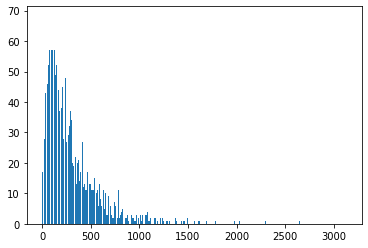

In [35]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(length_ele_list, length_list)
plt.show()

200과 400 사이에 갯수가 급격하게 줄어드는 위치가 보임

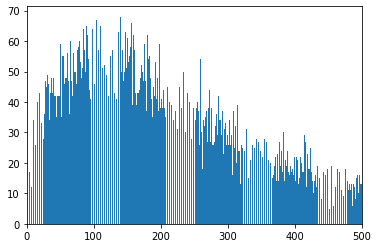

In [36]:
import matplotlib.pyplot as plt

plt.xlim(0, 500)
plt.bar(length_ele_list, length_list)
plt.show()

누적 분포로 데이터를 확인

In [37]:
all_count = len(train_review_length_lst)
x_list = []
y_list = []

b4 = 0

for thres in range(256, 512, 10):
    filtered_data = list(filter(lambda x: x<=thres, train_review_length_lst))
    count_data = len(filtered_data)
    
    x_list.append(thres)
    y_list.append(count_data)
    diff = count_data - b4
    print(f'{thres} : {count_data}, diff with before : {diff}')
    b4 = count_data

256 : 11514, diff with before : 11514
266 : 11828, diff with before : 314
276 : 12166, diff with before : 338
286 : 12474, diff with before : 308
296 : 12764, diff with before : 290
306 : 13052, diff with before : 288
316 : 13325, diff with before : 273
326 : 13563, diff with before : 238
336 : 13811, diff with before : 248
346 : 14056, diff with before : 245
356 : 14269, diff with before : 213
366 : 14505, diff with before : 236
376 : 14694, diff with before : 189
386 : 14890, diff with before : 196
396 : 15076, diff with before : 186
406 : 15258, diff with before : 182
416 : 15454, diff with before : 196
426 : 15633, diff with before : 179
436 : 15789, diff with before : 156
446 : 15941, diff with before : 152
456 : 16086, diff with before : 145
466 : 16213, diff with before : 127
476 : 16353, diff with before : 140
486 : 16467, diff with before : 114
496 : 16596, diff with before : 129
506 : 16710, diff with before : 114


마땅한 정보가 있어 보이진 않는다 (범위를 줄여도 마찬가지)

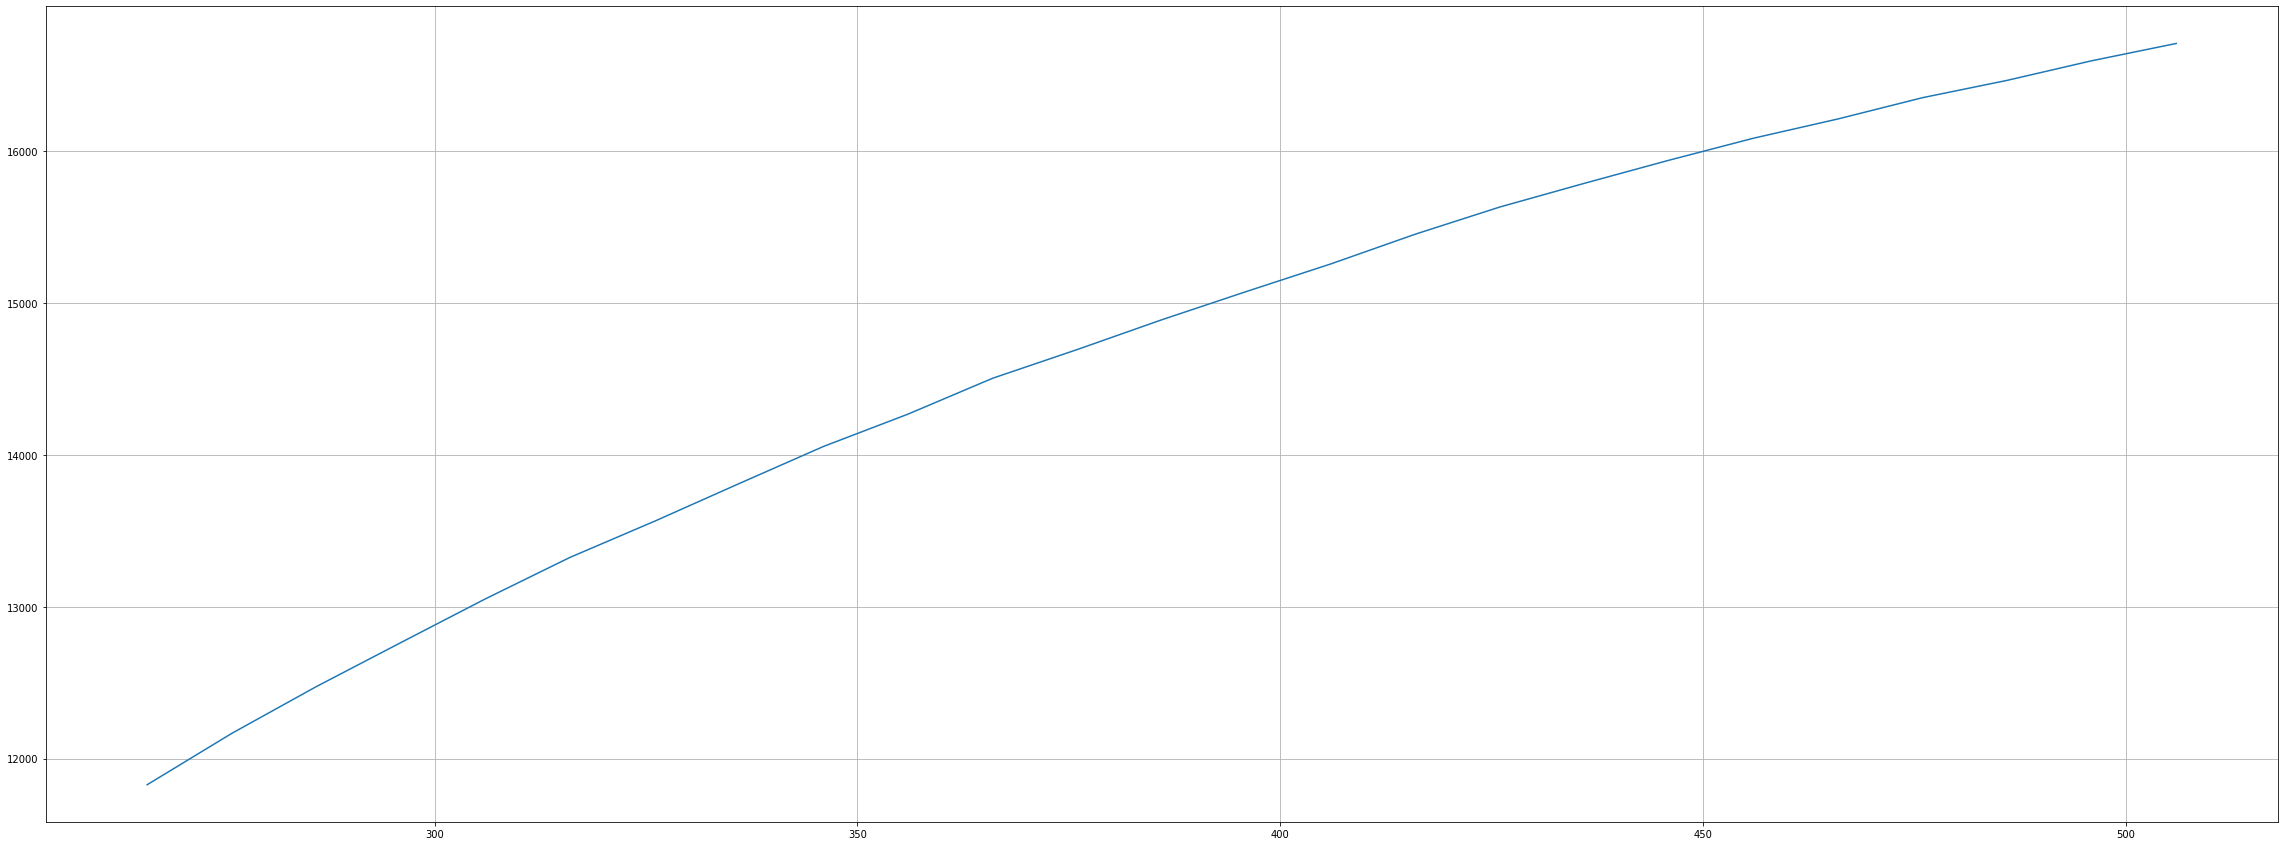

In [38]:
plt.figure(figsize=(40, 15))
plt.plot(x_list[1:], y_list[1:])
plt.grid(True)
plt.show()

In [39]:
x, y = 366, 236 # 실험을 통해 찾은 값

데이터의 범위를 줄여가며 누적 데이터 수의 차이가 급격히 차이가 줄어드는 지점을 찾음

In [40]:
all_count = len(train_review_length_lst)
x_list = []
y_list = []

b4 = 0

for thres in range(256, 513, 10):
    filtered_data = list(filter(lambda x: x<=thres, train_review_length_lst))
    count_data = len(filtered_data)
    
    x_list.append(thres)
#     y_list.append(count_data)
    diff = count_data - b4
    b4 = count_data
    y_list.append(diff)

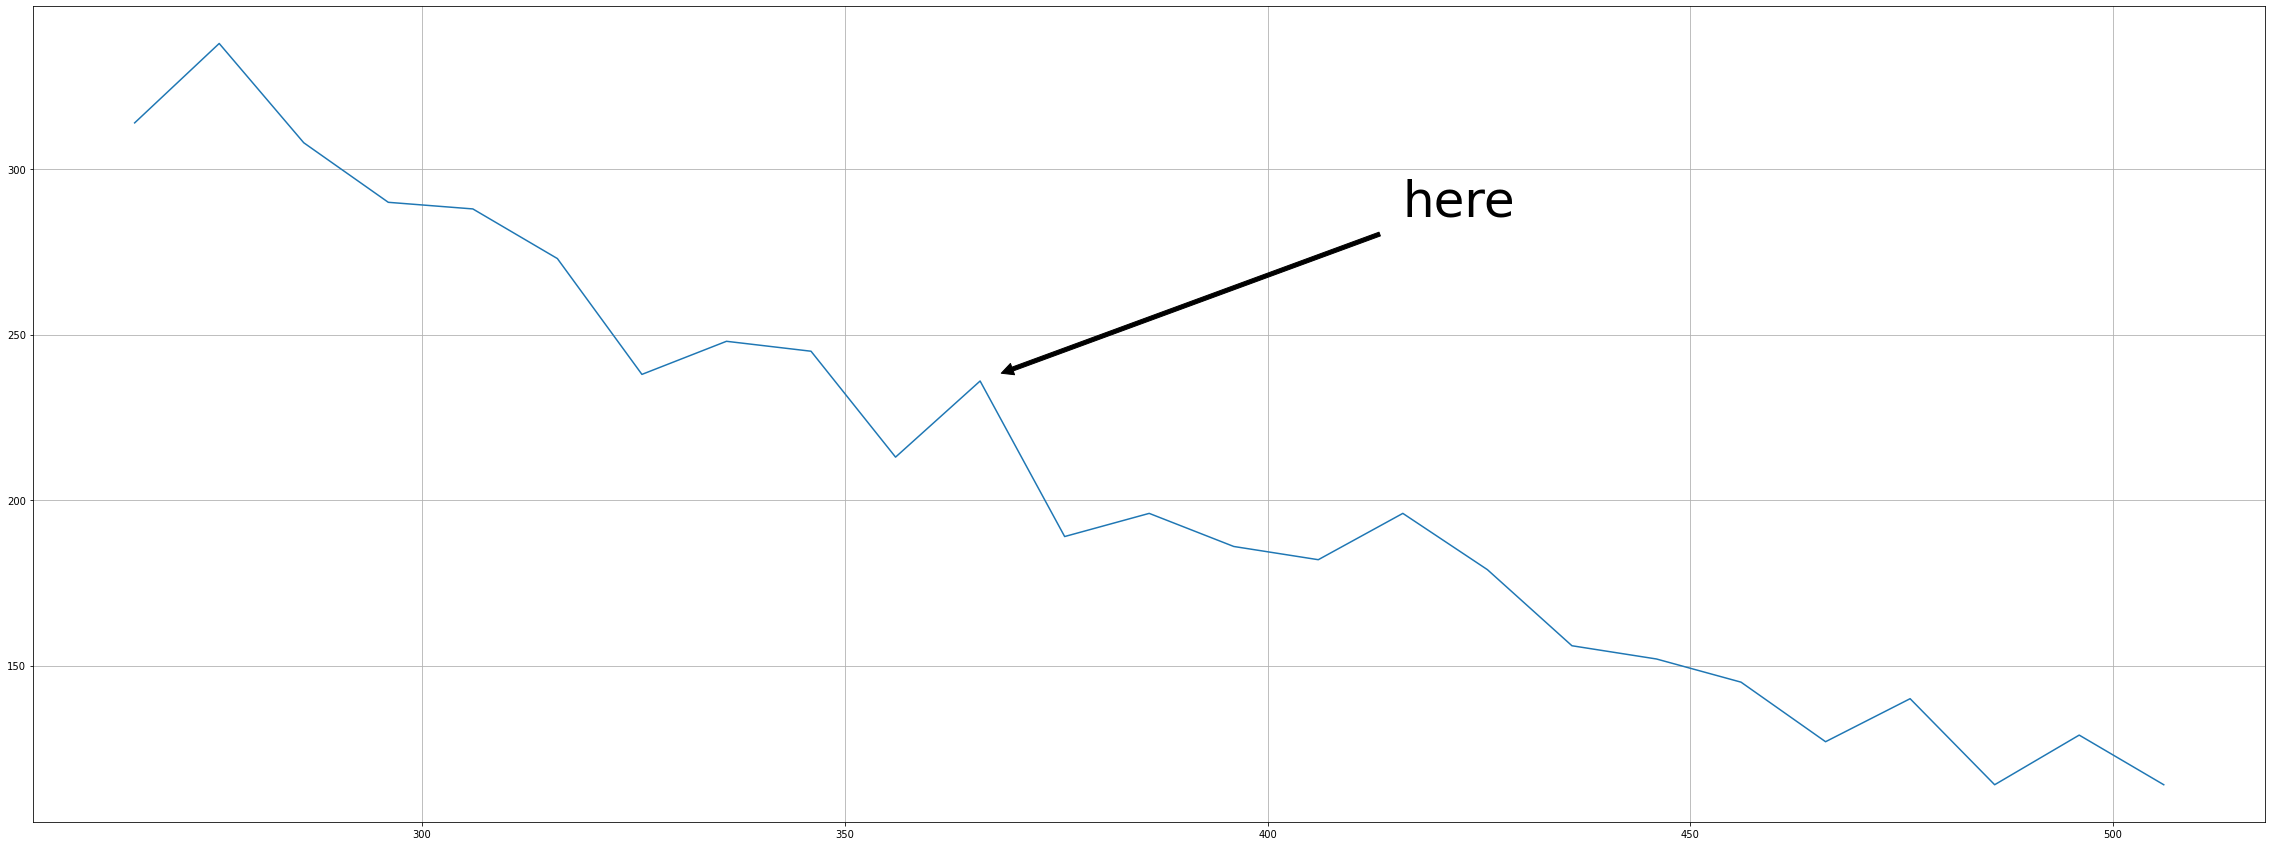

In [41]:
plt.figure(figsize=(40, 15))
plt.plot(x_list[1:], y_list[1:])
plt.annotate('here', xy=(x, y), xytext=(x + 50, y + 50),
             fontsize=50,
             arrowprops=dict(facecolor='black', shrink=0.05),
             )
plt.grid(True)
plt.show()

In [42]:
all_count = len(train_review_length_lst)
x_list = []
y_list = []

b4 = 0

for thres in range(256, 513, 5):
    filtered_data = list(filter(lambda x: x<=thres, train_review_length_lst))
    count_data = len(filtered_data)
    
    x_list.append(thres)
#     y_list.append(count_data)
    diff = count_data - b4
    b4 = count_data
    y_list.append(diff)

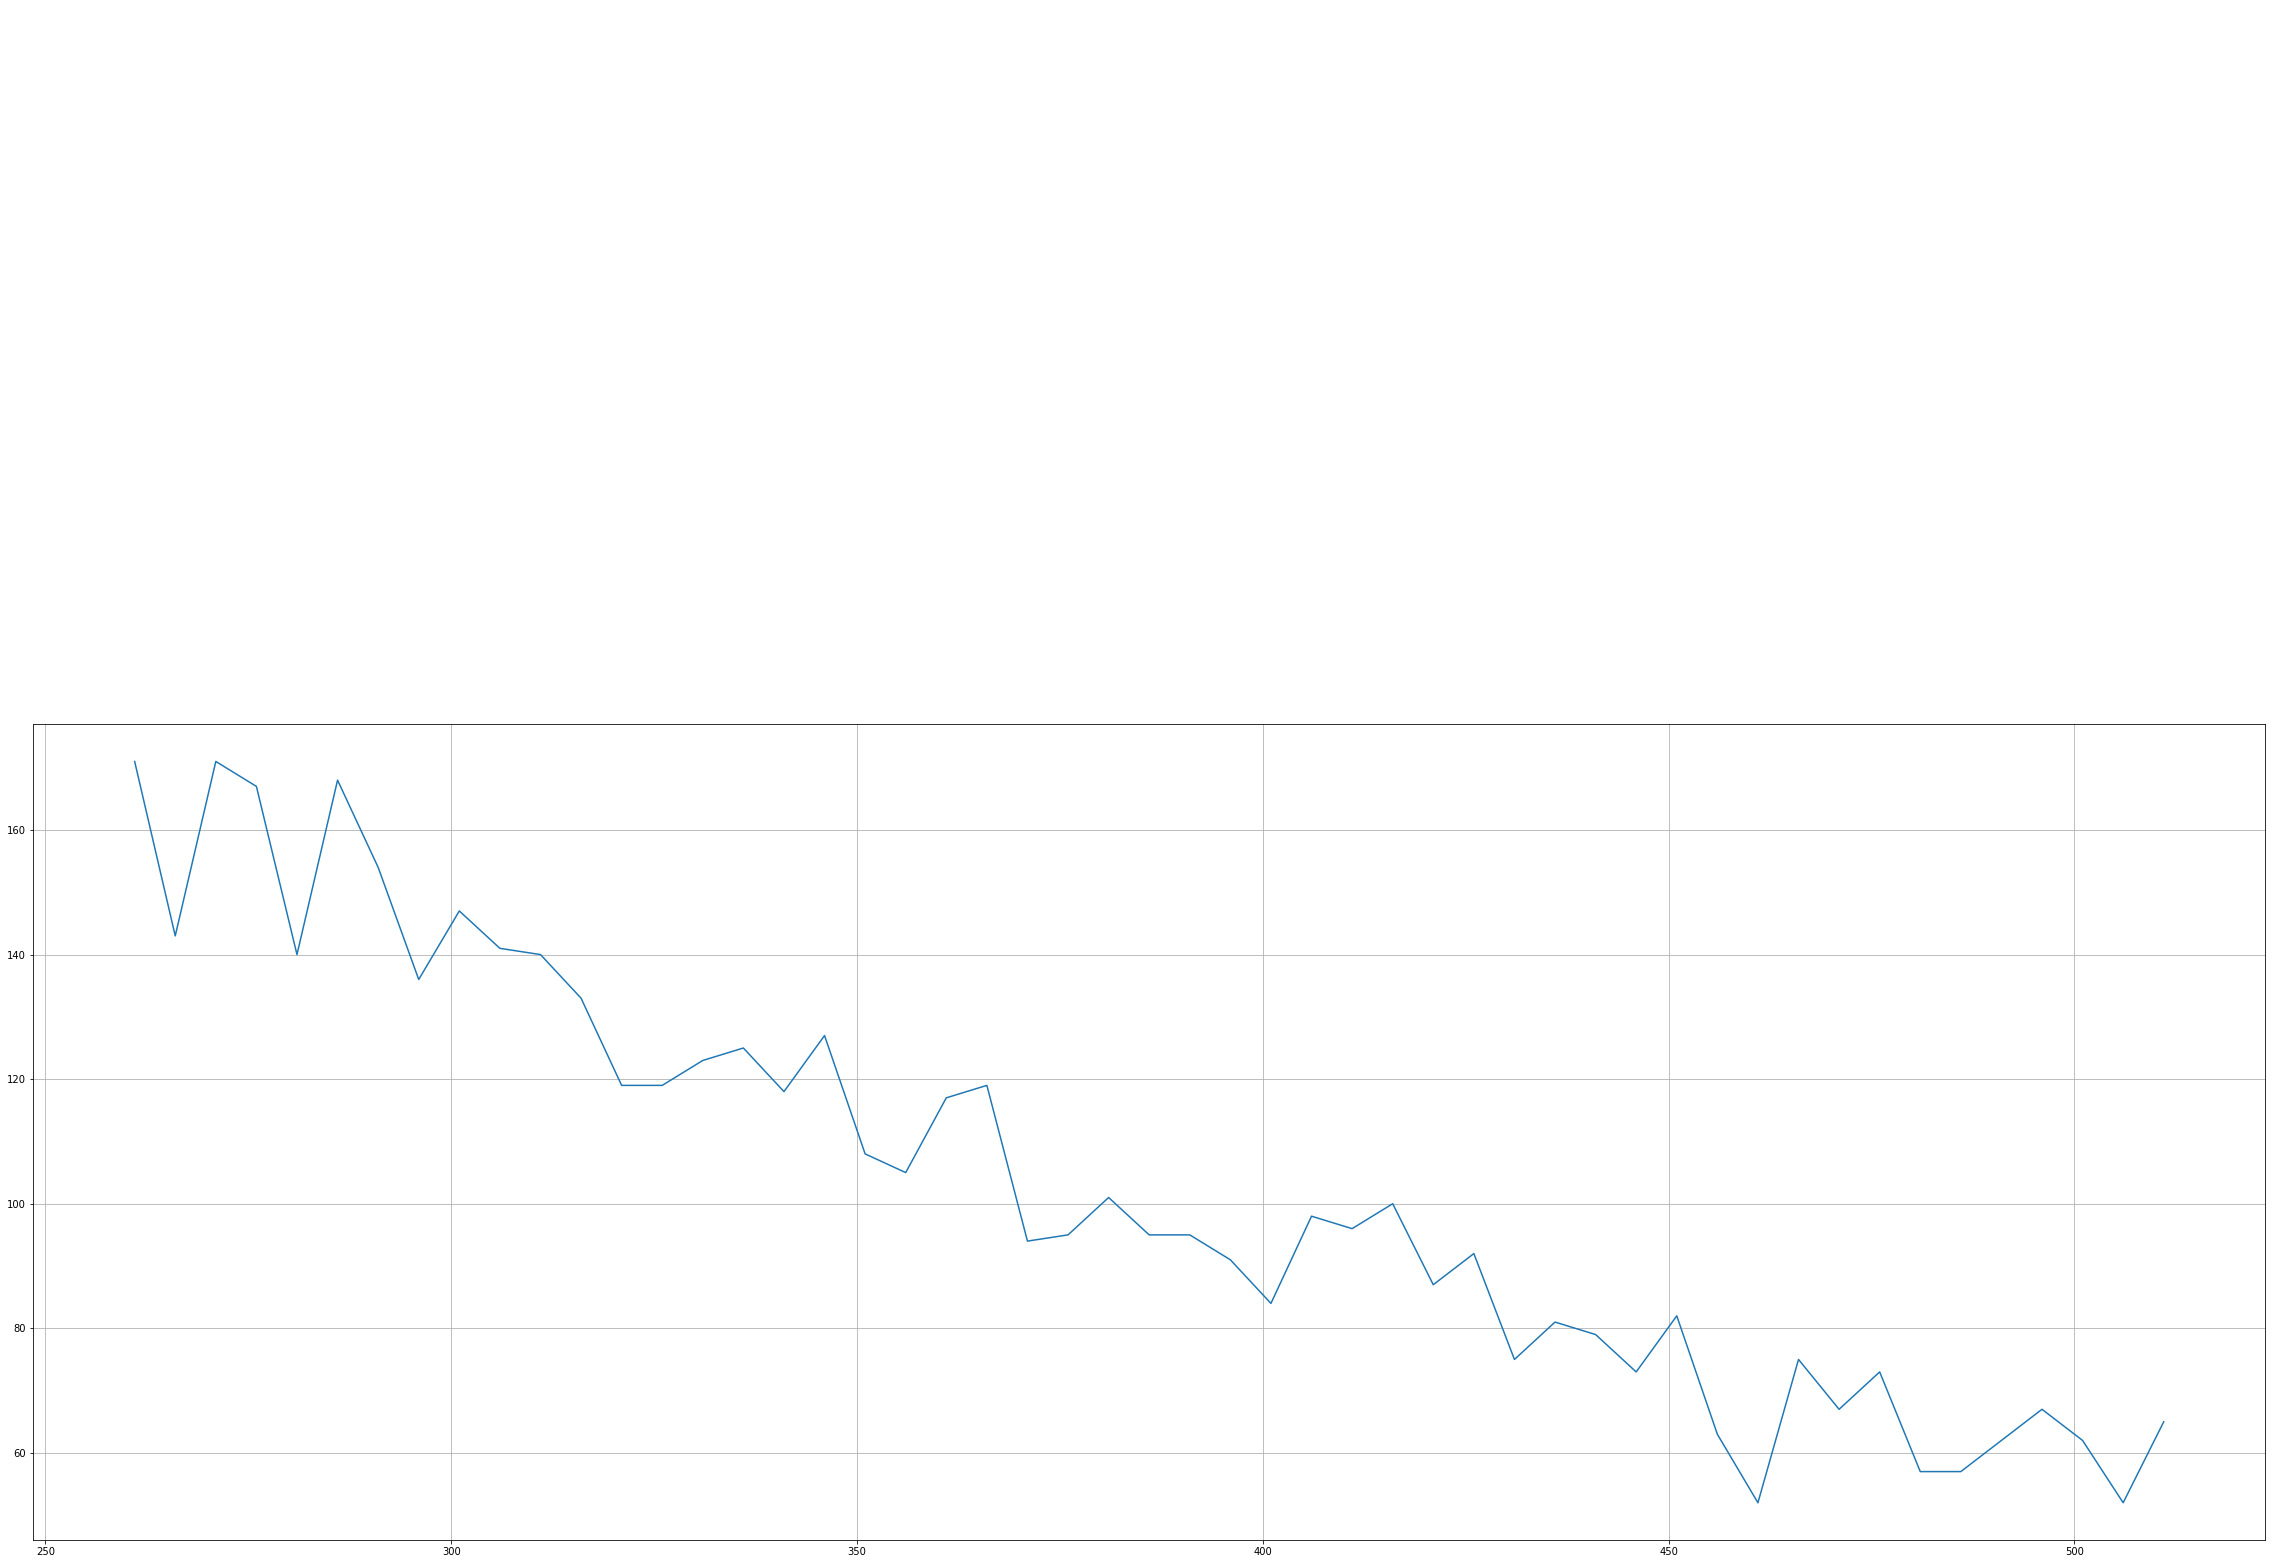

In [43]:
plt.figure(figsize=(40, 15))
plt.plot(x_list[1:], y_list[1:])
plt.annotate('here ', xy=(x, y), xytext=(x + 50, y + 50),
             fontsize=50,
             arrowprops=dict(facecolor='black', shrink=0.05),
             )
plt.grid(True)
plt.show()

In [44]:
all_count = len(train_review_length_lst)
x_list = []
y_list = []

b4 = 0

for thres in range(256, 513, 2):
    filtered_data = list(filter(lambda x: x<=thres, train_review_length_lst))
    count_data = len(filtered_data)
    
    x_list.append(thres)
#     y_list.append(count_data)
    diff = count_data - b4
    b4 = count_data
    y_list.append(diff)

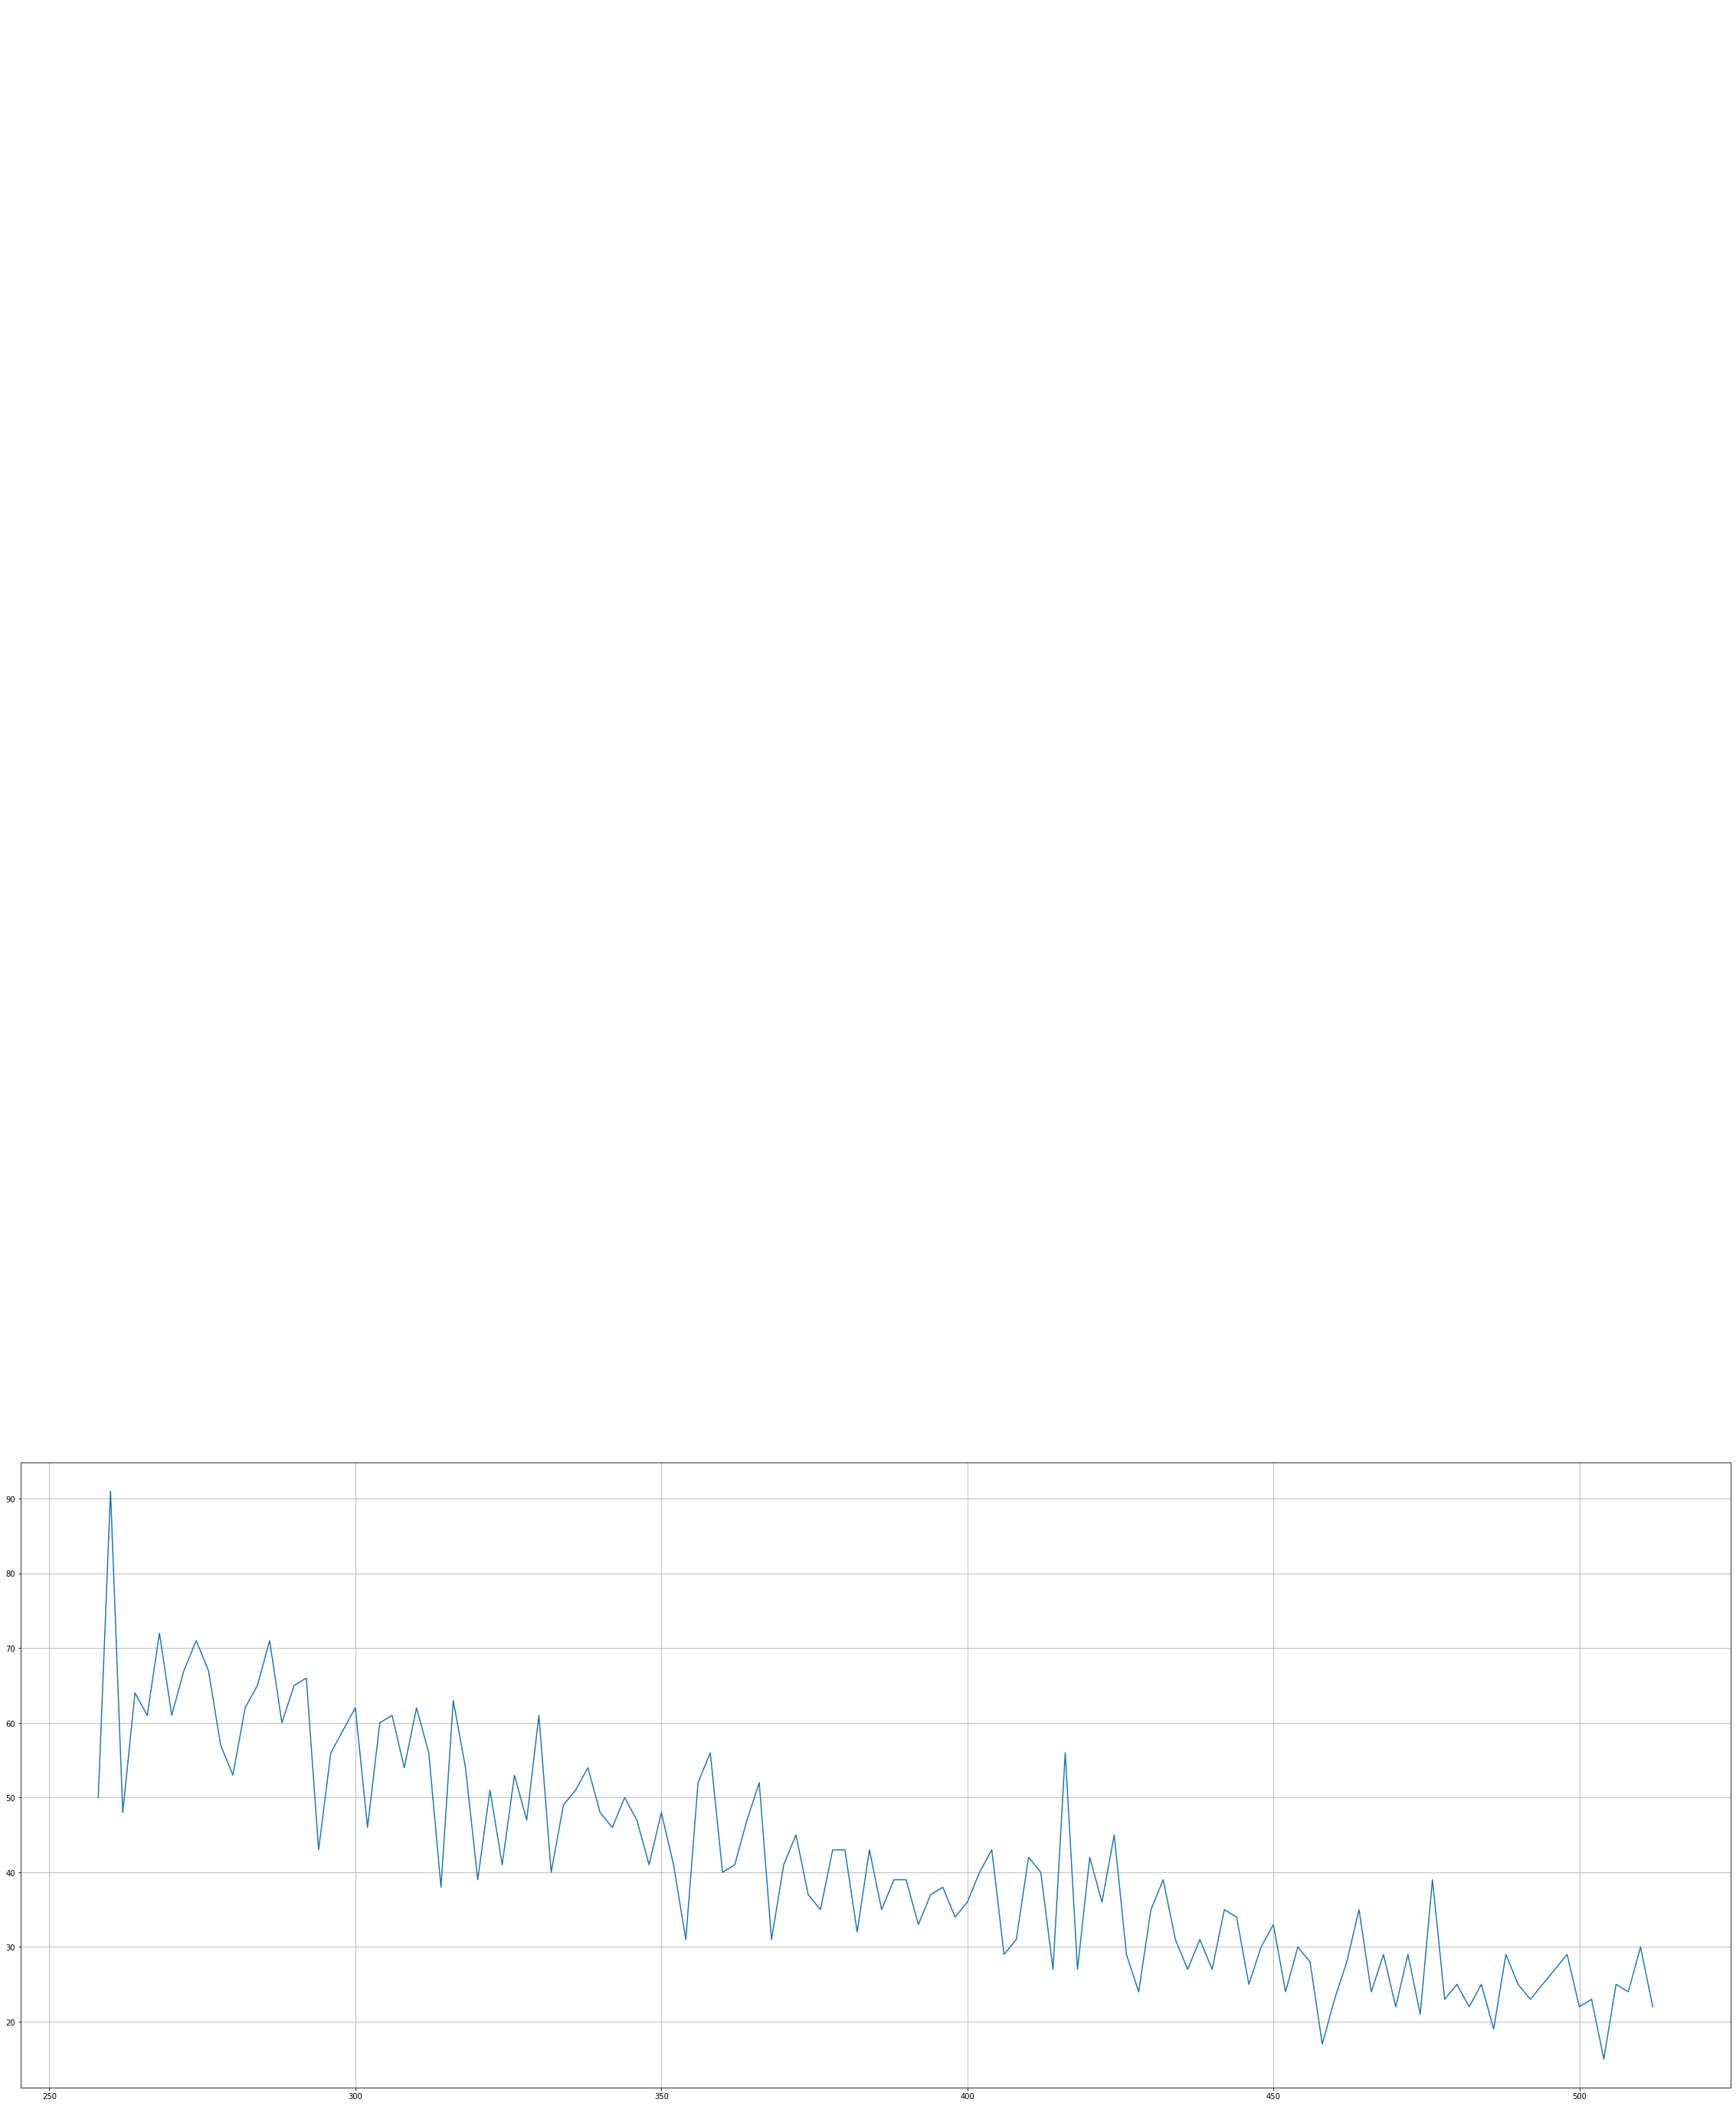

In [45]:
idx = 34

plt.figure(figsize=(40, 15))
plt.plot(x_list[1:], y_list[1:])
plt.annotate('here  ', xy=(x, y), xytext=(x + 50, y + 50),
             fontsize=50,
             arrowprops=dict(facecolor='black', shrink=0.05),
             )
plt.grid(True)
plt.show()

In [46]:
# df.comment_text[0]
df_train.review[0]

'moved greenpoint year ago lil cafe situation this place has opened kick ass work admit have been home oysterscheese addictive sidecars staff is hot its addition hood '

In [47]:
# target_columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
# df.iloc[[103]][target_columns]

target_columns = ["label"]
df.iloc[[103]][target_columns]

,label
103,1


In [48]:
df_train.shape

(20000, 5)

In [49]:
df_val.shape

(2000, 5)

In [50]:
df_test.shape

(4000, 5)

In [51]:
model_class = transformers.BertModel
tokenizer_class = transformers.BertTokenizer
pretrained_weights='bert-base-uncased'

In [52]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights).cuda()

누적 데이터 분포가 급격히 줄어드는 지점을 max_seq값으로 지정한다

In [53]:
max_seq = x

In [54]:
def tokenize_text(df, max_seq):
    return [
        # tokenizer.encode(text, add_special_tokens=True)[:max_seq] for text in df.comment_text.values
        tokenizer.encode(text, add_special_tokens=True)[:max_seq] for text in df.review.values
    ]


def pad_text(tokenized_text, max_seq):
    return np.array([el + [0] * (max_seq - len(el)) for el in tokenized_text])


def tokenize_and_pad_text(df, max_seq):
    tokenized_text = tokenize_text(df, max_seq)
    padded_text = pad_text(tokenized_text, max_seq)
    return torch.tensor(padded_text)


def targets_to_tensor(df, target_columns):
    return torch.tensor(df[target_columns].values, dtype=torch.float32)

In [55]:
train_indices = tokenize_and_pad_text(df_train, max_seq)
val_indices = tokenize_and_pad_text(df_val, max_seq)
test_indices = tokenize_and_pad_text(df_test, max_seq)

Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


In [56]:
train_indices = train_indices.cuda()
val_indices = val_indices.cuda()
test_indices = test_indices.cuda()

In [57]:
batch_size = 4

x_train = bert_model(train_indices[:batch_size])[0]
x_val = bert_model(val_indices[:batch_size])[0]
x_test = bert_model(test_indices[:batch_size])[0]

with torch.no_grad():
    print('train start!! : ', end='')
    for idx in tqdm(range(batch_size, len(train_indices), batch_size)):
        x_train = torch.cat((x_train, bert_model(train_indices[idx:idx+batch_size])[0]), 0)
        
    print('valid start!! : ', end='')
    for idx in tqdm(range(batch_size, len(val_indices), batch_size)):
        x_val = torch.cat((x_val, bert_model(val_indices[idx:idx+batch_size])[0]), 0)

    print('test start!! : ', end='')
    for idx in tqdm(range(batch_size, len(test_indices), batch_size)):
        x_test = torch.cat((x_test, bert_model(test_indices[idx:idx+batch_size])[0]), 0)

  0%|          | 6/4999 [00:00<01:36, 51.83it/s]

train start!! : 


 64%|██████▍   | 3213/4999 [14:16<07:56,  3.75it/s]


RuntimeError: CUDA out of memory. Tried to allocate 13.47 GiB (GPU 0; 31.72 GiB total capacity; 16.76 GiB already allocated; 13.47 GiB free; 17.04 GiB reserved in total by PyTorch)

In [ ]:
y_train = targets_to_tensor(df_train, target_columns)
y_val = targets_to_tensor(df_val, target_columns)
y_test = targets_to_tensor(df_test, target_columns)

In [ ]:
# x_train = np.array(x_train)
# x_val = np.array(x_val)
# x_test = np.array(x_test)

In [ ]:
x_train.shape

In [ ]:
class KimCNN(nn.Module):
    def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout, static):
        super(KimCNN, self).__init__()

        V = embed_num
        D = embed_dim
        C = class_num
        Co = kernel_num
        Ks = kernel_sizes
        
        self.static = static
        self.embed = nn.Embedding(V, D)
        self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, (K, D)) for K in Ks])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(Ks) * Co, C)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):
        if self.static:
            x = Variable(x)

        x = x.unsqueeze(1)  # (N, Ci, W, D)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)

        x = torch.cat(x, 1)
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        output = self.sigmoid(logit)
        return output

In [ ]:
embed_num = x_train.shape[1]
embed_dim = x_train.shape[2]
class_num = y_train.shape[1]
kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5
static = True

In [ ]:
model = KimCNN(
    embed_num=embed_num,
    embed_dim=embed_dim,
    class_num=class_num,
    kernel_num=kernel_num,
    kernel_sizes=kernel_sizes,
    dropout=dropout,
    static=static,
)

In [ ]:
model = model.to(device)

In [ ]:
n_epochs = 10
batch_size = 10
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

In [ ]:
def generate_batch_data(x, y, batch_size):
    i, batch = 0, 0
    for batch, i in enumerate(range(0, len(x) - batch_size, batch_size), 1):
        x_batch = x[i : i + batch_size]
        y_batch = y[i : i + batch_size]
        yield x_batch, y_batch, batch
    if i + batch_size < len(x):
        yield x[i + batch_size :], y[i + batch_size :], batch + 1
    if batch == 0:
        yield x, y, 1

In [ ]:
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    start_time = time.time()
    train_loss = 0

    model.train(True)
    for x_batch, y_batch, batch in generate_batch_data(x_train, y_train, batch_size):
        y_pred = model(x_batch)
        optimizer.zero_grad()
        y_pred = y_pred.cpu()
        loss = loss_fn(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= batch
    train_losses.append(train_loss)
    elapsed = time.time() - start_time

    model.eval() # disable dropout for deterministic output
    with torch.no_grad(): # deactivate autograd engine to reduce memory usage and speed up computations
        val_loss, batch = 0, 1
        for x_batch, y_batch, batch in generate_batch_data(x_val, y_val, batch_size):
            y_pred = model(x_batch)
            y_pred = y_pred.cpu()
            loss = loss_fn(y_pred, y_batch)
            val_loss += loss.item()
        val_loss /= batch
        val_losses.append(val_loss)

    print(
        "Epoch %d Train loss: %.2f. Validation loss: %.2f. Elapsed time: %.2fs."
        % (epoch + 1, train_losses[-1], val_losses[-1], elapsed)
    )

In [ ]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title("Losses")

In [ ]:
model.eval() # disable dropout for deterministic output
with torch.no_grad(): # deactivate autograd engine to reduce memory usage and speed up computations
    y_preds = []
    batch = 0
    for x_batch, y_batch, batch in generate_batch_data(x_test, y_test, batch_size):
        y_pred = model(x_batch)
        y_preds.extend(y_pred.cpu().numpy().tolist())
    y_preds_np = np.array(y_preds)

In [ ]:
y_preds_np

In [ ]:
y_test_np = df_test[target_columns].values

In [ ]:
y_test_np[1000:]

In [ ]:
auc_scores = roc_auc_score(y_test_np, y_preds_np, average=None)
df_accuracy = pd.DataFrame({"label": target_columns, "auc": auc_scores})
df_accuracy.sort_values('auc')[::-1]

In [ ]:
positive_labels = df_train[target_columns].sum().sum()
positive_labels

In [ ]:
all_labels = df_train[target_columns].count().sum()
all_labels

In [ ]:
positive_labels/all_labels

In [ ]:
df_test_targets = df_test[target_columns]
df_pred_targets = pd.DataFrame(y_preds_np.round(), columns=target_columns, dtype=int)
df_sanity = df_test_targets.join(df_pred_targets, how='inner', rsuffix='_pred')

In [ ]:
df_sanity

In [ ]:
df_test_targets.sum()

In [ ]:
df_pred_targets.sum()

In [ ]:
df_sanity[df_sanity.label > 0][['label', 'label_pred']]